> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [2]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32, name="D_a")#tf.Variable([1.0], dtype=tf.float32, 
                                   #name="D_a", 
                                   #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.constant(0.0, dtype=tf.float32, name="sigma_a")#tf.Variable([0.0], dtype=tf.float32)#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.02, dtype=tf.float32, name="rho_s")
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.25, dtype=tf.float32)#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        

        self.loss = self.loss_1 + 100*self.loss_a + 1000*self.loss_s 

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_t_temp = tf.identity(a_t, name="temp_a_t")
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        a_diff_temp = tf.identity(a_xx + a_yy, name="temp_a_diff")
        
        s_t = tf.gradients(s, t, name="s_t")[0]
        s_t_temp = tf.identity(s_t, name="temp_s_t")
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        s_diff_temp = tf.identity(s_xx + s_yy, name="temp_s_diff")
        
        f = a*a*s/(1 + kappa_a*a*a)
        kin_temp = tf.identity(f, name="temp_kin")
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 
        
        

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100): 
        
        

        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]

                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()

            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]

                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break    
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [4]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [5]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
model.train_batch(50000, batch_size=N*T//32, early_stop_thresh=2.0, print_iter=100)

It: 0, loss_a  : 40424.93241811, loss_s  : 18059.20498276, loss  : 22227414.40625,
D_a: 0.004999999888241291, D_s: [0.9990627765655518]
sigma_a: 0.0, sigma_s: [0.9714006185531616]
rho_a: [0.967879593372345], rho_s: [1.032326579093933]
mu_a: [0.9660879373550415], kappa_a: [0.9769911170005798], 
Time:5.59

It: 100, loss_a  : 2.08116314, loss_s  : 2.10176155, loss  : 96503.23388671875,
D_a: 0.004999999888241291, D_s: [1.5178724527359009]
sigma_a: 0.0, sigma_s: [0.678743839263916]
rho_a: [0.01798228546977043], rho_s: [1.5690134763717651]
mu_a: [9.99999993922529e-09], kappa_a: [0.6253252029418945], 
Time:256.53

It: 200, loss_a  : 0.00000032, loss_s  : 0.07146074, loss  : 80755.60473632812,
D_a: 0.004999999888241291, D_s: [1.6498128175735474]
sigma_a: 0.0, sigma_s: [0.4995635151863098]
rho_a: [3.598717739805579e-06], rho_s: [1.73829984664917]
mu_a: [9.99999993922529e-09], kappa_a: [0.3182436525821686], 
Time:257.46

It: 300, loss_a  : 0.00000004, loss_s  : 0.11644641, loss  : 26422.10382080

It: 2700, loss_a  : 0.00000240, loss_s  : 0.01043893, loss  : 9885.446502685547,
D_a: 0.004999999888241291, D_s: [0.9828757047653198]
sigma_a: 0.0, sigma_s: [0.6695745587348938]
rho_a: [7.677685061935335e-05], rho_s: [1.1211848258972168]
mu_a: [6.802684220019728e-05], kappa_a: [1.134793996810913], 
Time:240.68

It: 2800, loss_a  : 0.00007214, loss_s  : 0.00911820, loss  : 9880.555847167969,
D_a: 0.004999999888241291, D_s: [0.7634074687957764]
sigma_a: 0.0, sigma_s: [0.6665930151939392]
rho_a: [6.908513023518026e-05], rho_s: [1.1190506219863892]
mu_a: [6.878649583086371e-05], kappa_a: [1.1406276226043701], 
Time:261.52

It: 2900, loss_a  : 0.00007194, loss_s  : 0.03157520, loss  : 9900.346252441406,
D_a: 0.004999999888241291, D_s: [0.601942777633667]
sigma_a: 0.0, sigma_s: [0.6636121273040771]
rho_a: [0.00012252731539774686], rho_s: [1.1172568798065186]
mu_a: [3.445259790169075e-05], kappa_a: [1.146233081817627], 
Time:250.84

It: 3000, loss_a  : 0.00001037, loss_s  : 0.00729503, loss  

It: 5400, loss_a  : 0.04208434, loss_s  : 0.00000004, loss  : 30.09798514842987,
D_a: 0.004999999888241291, D_s: [1.4944340591682703e-06]
sigma_a: 0.0, sigma_s: [1.4869735309730459e-07]
rho_a: [0.0012460234574973583], rho_s: [9.99999993922529e-09]
mu_a: [9.99999993922529e-09], kappa_a: [3.035567045211792], 
Time:237.08

It: 5500, loss_a  : 0.03982526, loss_s  : 0.00048167, loss  : 21.51471710205078,
D_a: 0.004999999888241291, D_s: [0.00021515983098652214]
sigma_a: 0.0, sigma_s: [9.99999993922529e-09]
rho_a: [0.0008878898806869984], rho_s: [9.99999993922529e-09]
mu_a: [9.99999993922529e-09], kappa_a: [1.703087568283081], 
Time:253.43

It: 5600, loss_a  : 0.00519101, loss_s  : 0.00000005, loss  : 14.269532799720764,
D_a: 0.004999999888241291, D_s: [4.486156740313163e-06]
sigma_a: 0.0, sigma_s: [9.99999993922529e-09]
rho_a: [0.009063276462256908], rho_s: [1.2046658071085403e-07]
mu_a: [0.009071909822523594], kappa_a: [0.25302332639694214], 
Time:259.74

It: 5700, loss_a  : 0.00462460, los

In [14]:
model.minimise(max_iter=100)

loss: 1.9015028476715088, loss_a: 0.002354229800403118, loss_s: 3.221666338504292e-05,
D_a: 0.004999999888241291, D_s: [3.4514177968958393e-06]
sigma_a: 0.0, sigma_s: [9.99999993922529e-09]
rho_a: [0.009671487845480442], rho_s: [2.685054460016545e-05]
mu_a: [0.00948366429656744], kappa_a: [0.2620893716812134]

loss: 33051752.0, loss_a: 2829.77099609375, loss_s: 32735.798828125,
D_a: 0.004999999888241291, D_s: [0.020990947261452675]
sigma_a: 0.0, sigma_s: [0.5528205037117004]
rho_a: [-0.13664138317108154], rho_s: [-0.7658213376998901]
mu_a: [0.1505378633737564], kappa_a: [0.26398196816444397]

loss: 1.8630883693695068, loss_a: 0.0023241699673235416, loss_s: 1.7842237411969109e-06,
D_a: 0.004999999888241291, D_s: [3.963918061344884e-06]
sigma_a: 0.0, sigma_s: [1.3509494237951003e-05]
rho_a: [0.009667915292084217], rho_s: [8.149060704454314e-06]
mu_a: [0.009487108327448368], kappa_a: [0.26208943128585815]

loss: 1.8556013107299805, loss_a: 0.0023013148456811905, loss_s: 1.506838771092589e

loss: 1.2836326360702515, loss_a: 0.002238860120996833, loss_s: 2.421883671388514e-08,
D_a: 0.004999999888241291, D_s: [3.294769385320251e-06]
sigma_a: 0.0, sigma_s: [7.213159847196948e-07]
rho_a: [0.00965758878737688], rho_s: [6.795301601414394e-07]
mu_a: [0.009507580660283566], kappa_a: [0.26208317279815674]

loss: 1.2809303998947144, loss_a: 0.002237991662696004, loss_s: 2.344778238239087e-08,
D_a: 0.004999999888241291, D_s: [3.079187990806531e-06]
sigma_a: 0.0, sigma_s: [6.118916644481942e-07]
rho_a: [0.009658201597630978], rho_s: [5.776447551397723e-07]
mu_a: [0.009508387185633183], kappa_a: [0.2620816230773926]

loss: 1.2843371629714966, loss_a: 0.002238161861896515, loss_s: 2.254391873179884e-08,
D_a: 0.004999999888241291, D_s: [2.7119226615468506e-06]
sigma_a: 0.0, sigma_s: [1.1434845248459169e-07]
rho_a: [0.009658826515078545], rho_s: [1.0544285800051512e-07]
mu_a: [0.00951006356626749], kappa_a: [0.2620784342288971]

loss: 1.2799814939498901, loss_a: 0.0022379837464541197, lo

loss: 1.2669543027877808, loss_a: 0.0022381432354450226, loss_s: 2.2394278431647763e-08,
D_a: 0.004999999888241291, D_s: [3.3157232337543974e-06]
sigma_a: 0.0, sigma_s: [4.322384370425425e-07]
rho_a: [0.009659000672399998], rho_s: [4.492214316087484e-07]
mu_a: [0.009510446339845657], kappa_a: [0.26204219460487366]

loss: 1.2666338682174683, loss_a: 0.0022380673326551914, loss_s: 2.649221997330642e-08,
D_a: 0.004999999888241291, D_s: [3.152453246002551e-06]
sigma_a: 0.0, sigma_s: [9.385156545249629e-07]
rho_a: [0.009658106602728367], rho_s: [8.715426247363212e-07]
mu_a: [0.009509025141596794], kappa_a: [0.2620377242565155]

loss: 1.2663698196411133, loss_a: 0.0022380375303328037, loss_s: 6.424100718049885e-08,
D_a: 0.004999999888241291, D_s: [3.1858110105531523e-06]
sigma_a: 0.0, sigma_s: [9.119196420215303e-07]
rho_a: [0.009656545706093311], rho_s: [-1.9449996102594014e-07]
mu_a: [0.009508476592600346], kappa_a: [0.26203274726867676]

loss: 1.2666436433792114, loss_a: 0.002237958600744

loss: 1.2647802829742432, loss_a: 0.002238897141069174, loss_s: 2.2052336845490572e-08,
D_a: 0.004999999888241291, D_s: [3.009723968716571e-06]
sigma_a: 0.0, sigma_s: [3.581525049867196e-07]
rho_a: [0.009657418355345726], rho_s: [3.2665687399457966e-07]
mu_a: [0.009509295225143433], kappa_a: [0.2619946599006653]

loss: 1.2646547555923462, loss_a: 0.0022388803772628307, loss_s: 2.2113734843287602e-08,
D_a: 0.004999999888241291, D_s: [3.0255976071202895e-06]
sigma_a: 0.0, sigma_s: [2.3117800651561993e-07]
rho_a: [0.009657042101025581], rho_s: [2.0909587306050526e-07]
mu_a: [0.009509275667369366], kappa_a: [0.261995792388916]

loss: 1.2645798921585083, loss_a: 0.0022389283403754234, loss_s: 2.2029428947689667e-08,
D_a: 0.004999999888241291, D_s: [3.011168928424013e-06]
sigma_a: 0.0, sigma_s: [2.9735662110397243e-07]
rho_a: [0.009656840935349464], rho_s: [2.991614280745125e-07]
mu_a: [0.009509274736046791], kappa_a: [0.26199445128440857]

loss: 1.264501690864563, loss_a: 0.0022390056401491

loss: 1.262444019317627, loss_a: 0.0022379541769623756, loss_s: 2.2478058525621236e-08,
D_a: 0.004999999888241291, D_s: [3.0243243145378074e-06]
sigma_a: 0.0, sigma_s: [4.88285309074854e-07]
rho_a: [0.009654288180172443], rho_s: [3.6562192917699576e-07]
mu_a: [0.009507565759122372], kappa_a: [0.2618875503540039]

loss: 1.263720989227295, loss_a: 0.002240461762994528, loss_s: 3.0473398737740354e-07,
D_a: 0.004999999888241291, D_s: [3.90239802072756e-06]
sigma_a: 0.0, sigma_s: [-4.659711521526333e-06]
rho_a: [0.009650486521422863], rho_s: [-4.2097799450857565e-06]
mu_a: [0.009512384422123432], kappa_a: [0.2618669271469116]

loss: 1.2624247074127197, loss_a: 0.0022379709407687187, loss_s: 2.427472622912319e-08,
D_a: 0.004999999888241291, D_s: [3.116424295512843e-06]
sigma_a: 0.0, sigma_s: [-5.1681656287883015e-08]
rho_a: [0.009653889574110508], rho_s: [-1.1428631552234947e-07]
mu_a: [0.009508071467280388], kappa_a: [0.2618853747844696]

loss: 1.2623313665390015, loss_a: 0.0022379104048013

# Estimated parameters for a successful attempt, when we used hyper-parameter $\lambda = 100$ for penalising the PDE loss.

In [15]:
def print_vals(name, value, actual):
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/actual:0.8f}")
    
print(f"D_a: {model.sess.run(model.D_a):0.8f}, actual: 0.005, "
      f"difference: {np.abs(0.005-model.sess.run(model.D_a)):0.8f}, relative: %{100*np.abs(0.005-model.sess.run(model.D_a))/0.005:0.8f}")
print("---------------")
print_vals("D_s", model.sess.run(model.D_s)[0], 0.2)
print_vals("sigma_s", model.sess.run(model.sigma_s)[0], 0.02)
print_vals("rho_a", model.sess.run(model.rho_a)[0], 0.01)
print_vals("mu_a", model.sess.run(model.mu_a)[0], 0.01)
print_vals("kappa_a", model.sess.run(model.kappa_a)[0], 0.25)

D_a: 0.00500000, actual: 0.005, difference: 0.00000000, relative: %0.00000224
---------------
D_s: 0.00000308, actual: 0.200, difference: 0.19999692, relative: %99.99845798
sigma_s: 0.00000004, actual: 0.020, difference: 0.01999996, relative: %99.99981879
rho_a: 0.00965438, actual: 0.010, difference: 0.00034562, relative: %3.45619619
mu_a: 0.00950850, actual: 0.010, difference: 0.00049150, relative: %4.91499193
kappa_a: 0.26187840, actual: 0.250, difference: 0.01187840, relative: %4.75136042


In [7]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [8]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))

tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00007335
Loss_s : 0.00000101
Loss   : 0.06255958


In [9]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.03273543094301541
0.0214815297963954


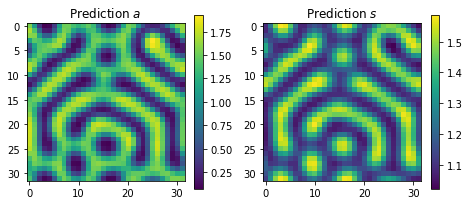

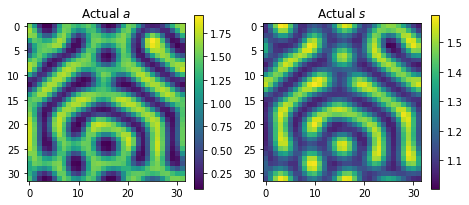

In [10]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [11]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin:0")
kin = model.sess.run(tmp, tf_dict)

D_a = 0.005000, rho_a = 0.009671, mu_a = 0.009483664, sigma_a = 0.000000000, kappa_a = 0.2621


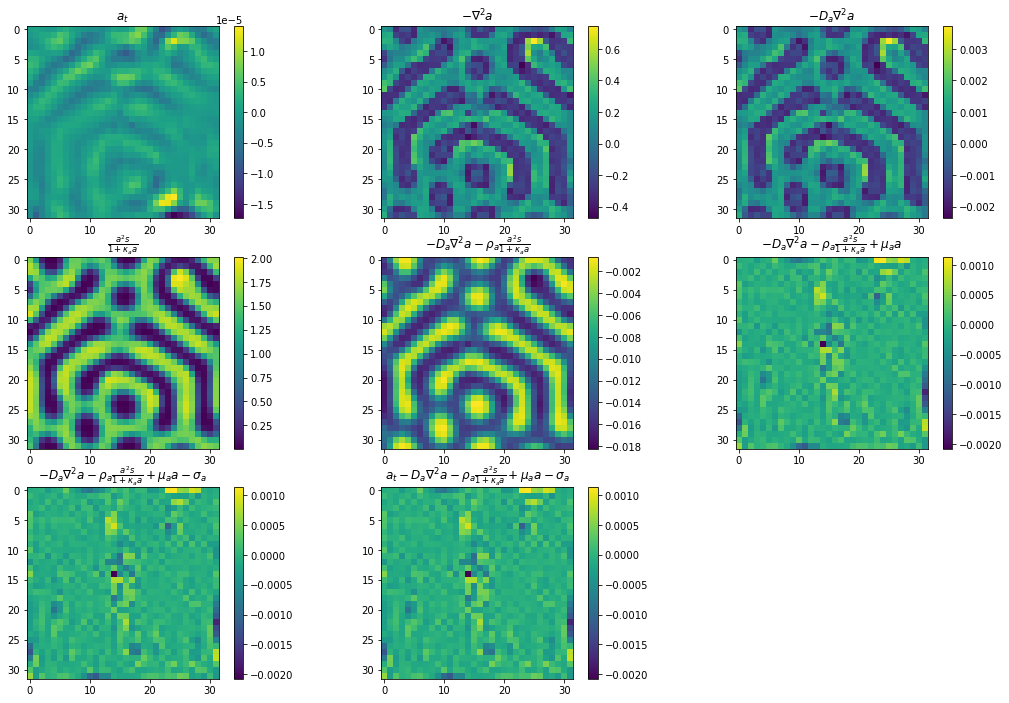

In [12]:
D_a = model.sess.run(model.D_a, tf_dict)
rho_a = model.sess.run(model.rho_a, tf_dict)
mu_a = model.sess.run(model.mu_a, tf_dict)
sigma_a = model.sess.run(model.sigma_a, tf_dict)
kappa_a = model.sess.run(model.kappa_a, tf_dict)[0]
print(f"D_a = {D_a:.6f}, rho_a = {rho_a[0]:.6f}, mu_a = {mu_a[0]:.9f}, sigma_a = {sigma_a:.9f}, kappa_a = {kappa_a:.4f}")

# a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_a \nabla^2 a$")
plt.imshow((-D_a*a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_a*a_diff-rho_a*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$a_t-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((a_t-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


D_s = 0.000003, rho_s = 0.000027, sigma_s = 0.000000, kappa_a = 0.2621


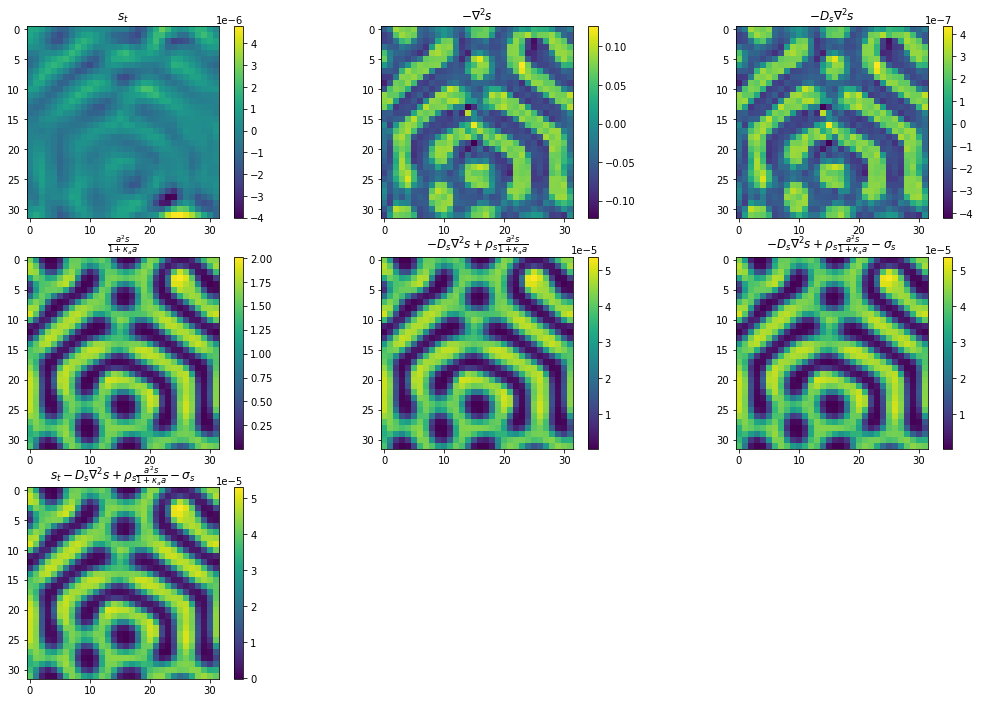

In [13]:
D_s = model.sess.run(model.D_s, tf_dict)
rho_s = model.sess.run(model.rho_s, tf_dict)
sigma_s = model.sess.run(model.sigma_s, tf_dict)
print(f"D_s = {D_s[0]:.6f}, rho_s = {rho_s[0]:.6f}, sigma_s = {sigma_s[0]:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_s \nabla^2 s$")
plt.imshow((-D_s*s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_s*s_diff+rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((-D_s*s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$s_t-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((s_t-D_s*s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()

# Estimated parameters for a failed attempt, when we used hyper-parameter $\lambda = 100$ for penalising the PDE loss.

# All $s$'s PDE parameters are unknown, so, it failed. We need to use an unbalanced hyper-parameter.

# The overal loss was below 2.0

In [6]:

def print_vals(name, value, actual):
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/actual:0.8f}")
    
print(f"D_a: {model.sess.run(model.D_a):0.8f}, actual: 0.005, "
      f"difference: {np.abs(0.005-model.sess.run(model.D_a)):0.8f}, relative: %{100*np.abs(0.005-model.sess.run(model.D_a))/0.005:0.8f}")
print("---------------")
print_vals("D_s", model.sess.run(model.D_s)[0], 0.2)
print_vals("sigma_s", model.sess.run(model.sigma_s)[0], 0.02)
print_vals("rho_a", model.sess.run(model.rho_a)[0], 0.01)
print_vals("mu_a", model.sess.run(model.mu_a)[0], 0.01)
print_vals("kappa_a", model.sess.run(model.kappa_a)[0], 0.01)

D_a: 0.00500000, actual: 0.005, difference: 0.00000000, relative: %0.00000224
---------------
D_s: 0.00000266, actual: 0.200, difference: 0.19999734, relative: %99.99866791
sigma_s: 0.00000081, actual: 0.020, difference: 0.01999919, relative: %99.99596019
rho_a: 0.00954826, actual: 0.010, difference: 0.00045174, relative: %4.51735444
mu_a: 0.00952523, actual: 0.010, difference: 0.00047477, relative: %4.74773571
kappa_a: 0.25319704, actual: 0.010, difference: 0.24319704, relative: %2431.97044134


In [7]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [8]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00004055
Loss_s : 0.00000000
Loss   : 0.07491203


In [9]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.05313761221433469
0.01771944456708618


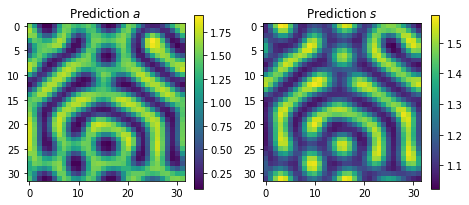

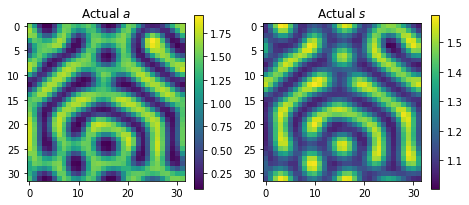

In [10]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [11]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin:0")
kin = model.sess.run(tmp, tf_dict)

D_a = 0.005000, rho_a = 0.009548, mu_a = 0.009525226, sigma_a = 0.000000000, kappa_a = 0.2532


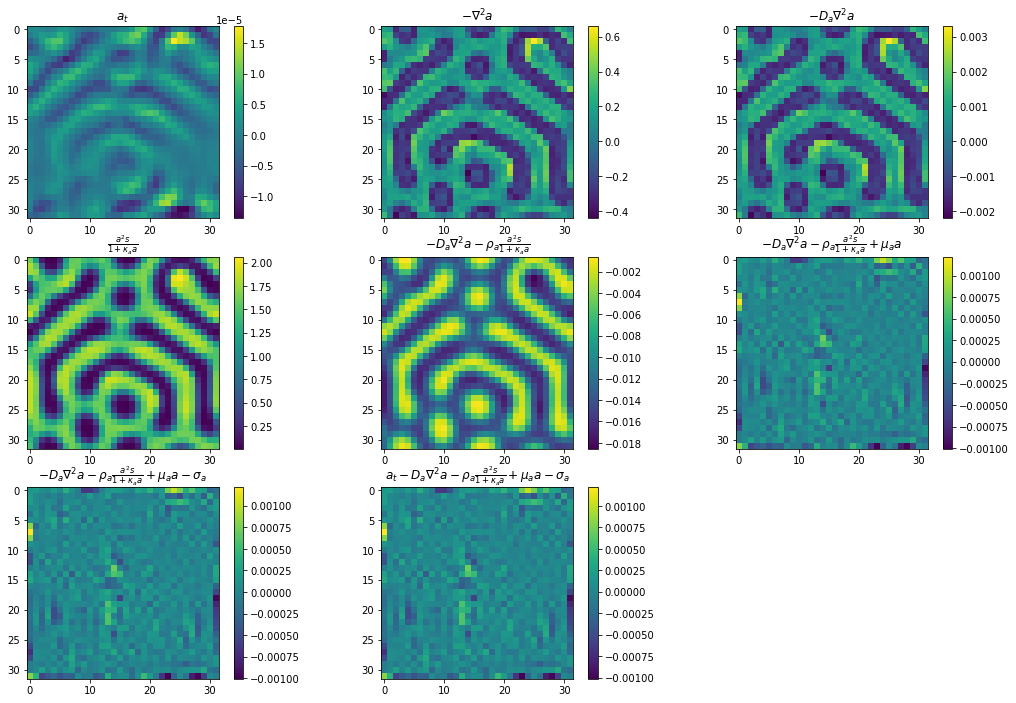

In [12]:
D_a = model.sess.run(model.D_a, tf_dict)
rho_a = model.sess.run(model.rho_a, tf_dict)
mu_a = model.sess.run(model.mu_a, tf_dict)
sigma_a = model.sess.run(model.sigma_a, tf_dict)
kappa_a = model.sess.run(model.kappa_a, tf_dict)[0]
print(f"D_a = {D_a:.6f}, rho_a = {rho_a[0]:.6f}, mu_a = {mu_a[0]:.9f}, sigma_a = {sigma_a:.9f}, kappa_a = {kappa_a:.4f}")

# a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_a \nabla^2 a$")
plt.imshow((-D_a*a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_a*a_diff-rho_a*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$a_t-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((a_t-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


D_s = 0.000003, rho_s = 0.000000, sigma_s = 0.000001, kappa_a = 0.2532


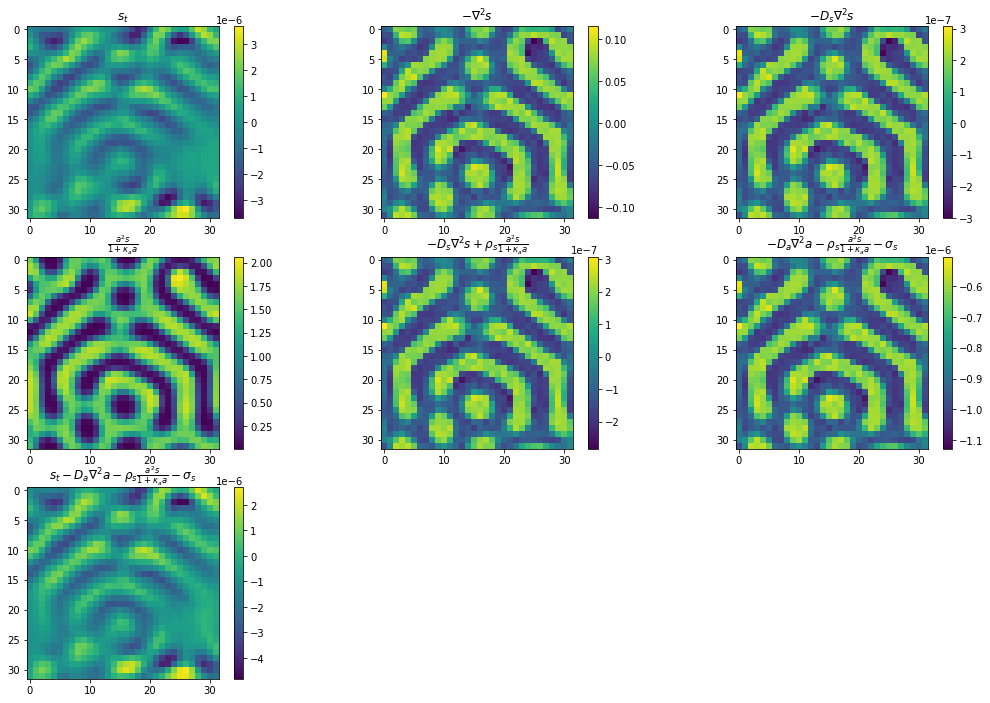

In [22]:
D_s = model.sess.run(model.D_s, tf_dict)
rho_s = model.sess.run(model.rho_s, tf_dict)
sigma_s = model.sess.run(model.sigma_s, tf_dict)
print(f"D_s = {D_s[0]:.6f}, rho_s = {rho_s[0]:.6f}, sigma_s = {sigma_s[0]:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_s \nabla^2 s$")
plt.imshow((-D_s*s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_s*s_diff+rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((-D_s*s_diff-rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$s_t-D_a \nabla^2 a - \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((s_t-D_s*s_diff-rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()